In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import required libraries

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

2.6.4


## helper functions

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


## Create the series using helper functions

In [4]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Create the dataset

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

2022-08-10 20:53:53.286460: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Build the model

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

## Train the model 

In [7]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-08-10 20:53:53.867130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
8/8 [==============================] - 2s 36ms/step - loss: 195.5727 - mae: 196.0727
Epoch 2/100
8/8 [==============================] - 0s 26ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 25ms/step - loss: 193.5110 - mae: 194.0110
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 187.8583 - mae: 188.3583
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 185.3787 - mae: 185.8787
Epoch 8/100
8/8 [==============================] - 0s 26ms/step - loss: 182.5484 - mae: 183.0484
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 179.3127 - mae: 179.8127
Epoch 10/100
8/8 [==============================] - 0s 29ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

## Visualize metrics

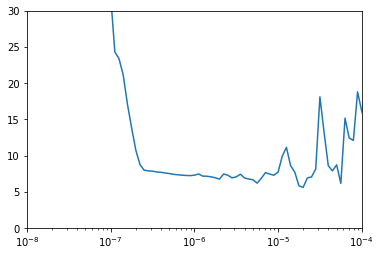

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])
plt.show()

## Retrain the model

In [9]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 53ms/step - loss: 18.6997 - mae: 19.1920
Epoch 2/400
8/8 [==============================] - 0s 29ms/step - loss: 15.1855 - mae: 15.6783
Epoch 3/400
8/8 [==============================] - 0s 26ms/step - loss: 15.6148 - mae: 16.1082
Epoch 4/400
8/8 [==============================] - 0s 28ms/step - loss: 10.9565 - mae: 11.4477
Epoch 5/400
8/8 [==============================] - 0s 28ms/step - loss: 18.4258 - mae: 18.9216
Epoch 6/400
8/8 [==============================] - 0s 30ms/step - loss: 19.3483 - mae: 19.8447
Epoch 7/400
8/8 [==============================] - 0s 29ms/step - loss: 13.5678 - mae: 14.0630
Epoch 8/400
8/8 [==============================] - 0s 25ms/step - loss: 13.2814 - mae: 13.7714
Epoch 9/400
8/8 [==============================] - 0s 27ms/step - loss: 12.8070 - mae: 13.3018
Epoch 10/400
8/8 [==============================] - 0s 27ms/step - loss: 14.0712 - mae: 14.5638
Epoch 11/400
8/8 [==============================]

## Forcasting using the trained model

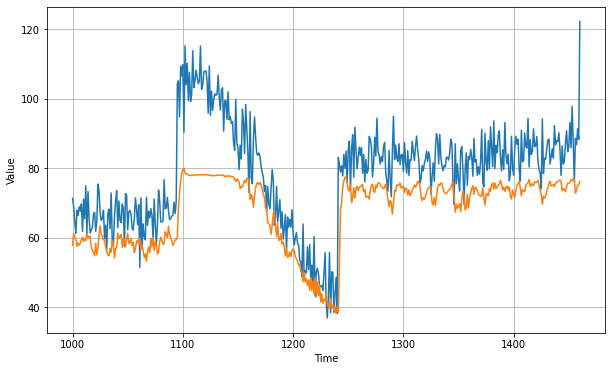

10.964885

In [11]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)
plt.show()

tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

<Figure size 432x288 with 0 Axes>

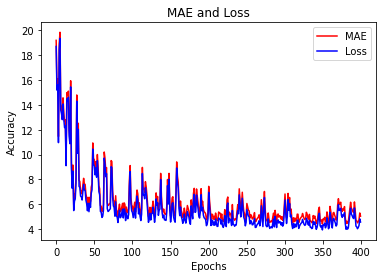

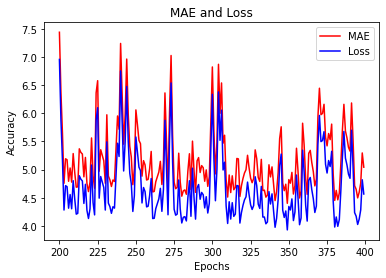

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()